# MedQA Generation Task Performance Analysis

This notebook analyzes the performance drop in `medqa_4options_generation` (0.4713) compared to the multiple-choice baseline (0.6316).

## Objectives
1. Analyze regex extraction failures
2. Compare model output formats
3. Identify root causes of performance drop
4. Compare with PubMedQA (which performs better at 0.762)


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load MedQA samples
medqa_samples_path = "samples_medqa_4options_generation_baseline.jsonl"
medqa_samples = []

with open(medqa_samples_path, 'r') as f:
    for line in f:
        if line.strip():
            medqa_samples.append(json.loads(line))

print(f"Loaded {len(medqa_samples)} MedQA samples")

# Load PubMedQA samples for comparison
pubmedqa_samples_path = "../pubmedqa/samples_pubmedqa_generation_baseline.jsonl"
pubmedqa_samples = []

try:
    with open(pubmedqa_samples_path, 'r') as f:
        for line in f:
            if line.strip():
                pubmedqa_samples.append(json.loads(line))
    print(f"Loaded {len(pubmedqa_samples)} PubMedQA samples")
except FileNotFoundError:
    print("PubMedQA samples not found, skipping comparison")
    pubmedqa_samples = []


Loaded 1273 MedQA samples
Loaded 500 PubMedQA samples


## 1. Overall Performance Statistics


In [2]:
# Calculate overall statistics
total = len(medqa_samples)
correct = sum(1 for s in medqa_samples if s.get('exact_match', 0) == 1.0)
incorrect = total - correct

print(f"Total samples: {total}")
print(f"Correct: {correct} ({100*correct/total:.2f}%)")
print(f"Incorrect: {incorrect} ({100*incorrect/total:.2f}%)")
print(f"\nPerformance: {correct/total:.4f}")

# Analyze extraction results
invalid_count = sum(1 for s in medqa_samples if s.get('filtered_resps', [''])[0] == '[invalid]')
valid_extraction = total - invalid_count

print(f"\nExtraction Statistics:")
print(f"Valid extractions: {valid_extraction} ({100*valid_extraction/total:.2f}%)")
print(f"Invalid fallback: {invalid_count} ({100*invalid_count/total:.2f}%)")


Total samples: 1273
Correct: 600 (47.13%)
Incorrect: 673 (52.87%)

Performance: 0.4713

Extraction Statistics:
Valid extractions: 1052 (82.64%)
Invalid fallback: 221 (17.36%)


## 2. Regex Extraction Analysis


In [3]:
# Current regex pattern from medqa.yaml
current_pattern = r'(?i)answer\W(?:is)*\W*([A-D])(?:\W|$)|(?:answer|boxed)?{\W*([A-D])\W+'

def test_regex_extraction(text, pattern):
    """Test regex pattern and return extracted value and all matches."""
    regex = re.compile(pattern)
    matches = regex.findall(text)
    
    if not matches:
        return None, []
    
    first_match = matches[0]
    if isinstance(first_match, tuple):
        extracted = [m for m in first_match if m]
        extracted = extracted[0].strip() if extracted else None
    else:
        extracted = first_match.strip() if first_match else None
    
    return extracted, matches

# Analyze extraction for each sample
extraction_analysis = []

for sample in medqa_samples:
    target = sample.get('target', '')
    filtered_resp = sample.get('filtered_resps', [''])[0] if sample.get('filtered_resps') else ''
    raw_resp = sample.get('resps', [['']])[0][0] if sample.get('resps') else ''
    exact_match = sample.get('exact_match', 0)
    
    extracted, all_matches = test_regex_extraction(raw_resp, current_pattern)
    
    extraction_analysis.append({
        'doc_id': sample.get('doc_id'),
        'target': target,
        'filtered_resp': filtered_resp,
        'extracted': extracted,
        'raw_resp_length': len(raw_resp),
        'exact_match': exact_match,
        'is_invalid': filtered_resp == '[invalid]',
        'extraction_correct': extracted == target if extracted else False,
        'num_matches': len(all_matches),
    })

df_extraction = pd.DataFrame(extraction_analysis)

print("Extraction Analysis Summary:")
print(f"Total samples: {len(df_extraction)}")
print(f"Invalid fallback: {df_extraction['is_invalid'].sum()} ({100*df_extraction['is_invalid'].mean():.2f}%)")
print(f"Extraction matches target: {df_extraction['extraction_correct'].sum()} ({100*df_extraction['extraction_correct'].mean():.2f}%)")
print(f"Average matches per sample: {df_extraction['num_matches'].mean():.2f}")


Extraction Analysis Summary:
Total samples: 1273
Invalid fallback: 221 (17.36%)
Extraction matches target: 600 (47.13%)
Average matches per sample: 1.16


Failure Mode Distribution:
  correct: 600 (47.13%)
  wrong_answer_extracted: 452 (35.51%)
  extraction_failure: 221 (17.36%)


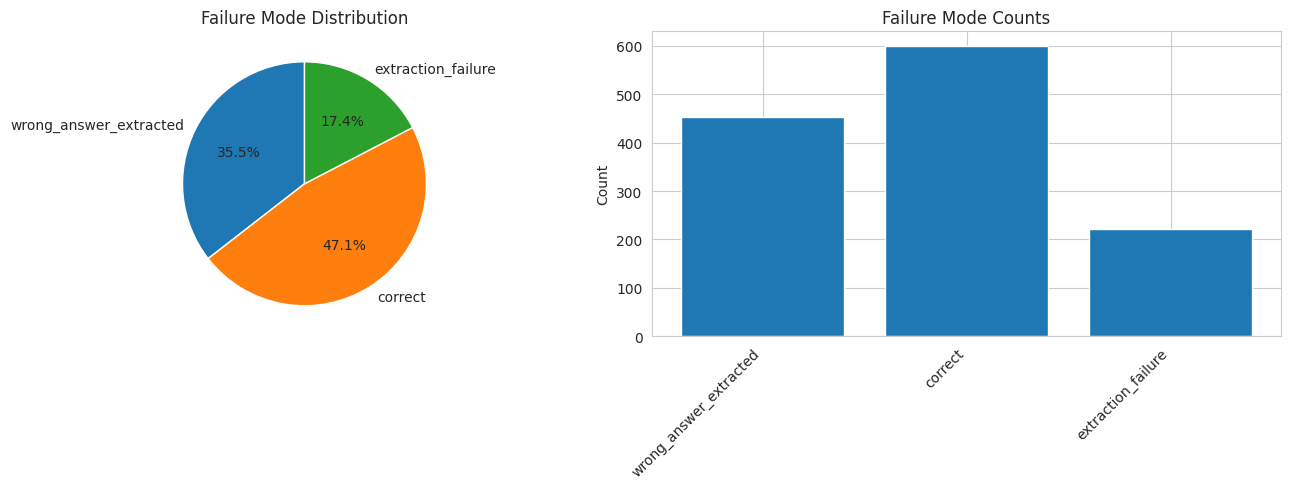

In [4]:
# Categorize failure modes
failure_modes = []

for sample in medqa_samples:
    target = sample.get('target', '')
    filtered_resp = sample.get('filtered_resps', [''])[0] if sample.get('filtered_resps') else ''
    raw_resp = sample.get('resps', [['']])[0][0] if sample.get('resps') else ''
    exact_match = sample.get('exact_match', 0)
    
    if exact_match == 1.0:
        mode = 'correct'
    elif filtered_resp == '[invalid]':
        mode = 'extraction_failure'
    elif filtered_resp != target:
        mode = 'wrong_answer_extracted'
    else:
        mode = 'unknown'
    
    failure_modes.append(mode)

failure_counter = Counter(failure_modes)

print("Failure Mode Distribution:")
for mode, count in failure_counter.most_common():
    print(f"  {mode}: {count} ({100*count/len(failure_modes):.2f}%)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of failure modes
ax1.pie(failure_counter.values(), labels=failure_counter.keys(), autopct='%1.1f%%', startangle=90)
ax1.set_title('Failure Mode Distribution')

# Bar chart
ax2.bar(failure_counter.keys(), failure_counter.values())
ax2.set_title('Failure Mode Counts')
ax2.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 3. Model Output Format Analysis


In [5]:
# Categorize output formats
def categorize_output_format(text):
    """Categorize the format of model output."""
    if not text or text.strip() == '':
        return 'empty'
    text_lower = text.lower()
    
    if 'boxed{' in text_lower:
        return 'boxed_format'
    elif re.search(r'answer\s*[:\-]?\s*[A-D]', text, re.I):
        return 'answer_colon'
    elif re.search(r'the\s+answer\s+is\s+[A-D]', text, re.I):
        return 'answer_is'
    elif re.search(r'\b([A-D])\b', text):
        return 'standalone_letter'
    else:
        return 'other'

output_formats = []
for sample in medqa_samples:
    raw_resp = sample.get('resps', [['']])[0][0] if sample.get('resps') else ''
    format_type = categorize_output_format(raw_resp)
    output_formats.append(format_type)

format_counter = Counter(output_formats)

print("Output Format Distribution:")
for fmt, count in format_counter.most_common():
    print(f"  {fmt}: {count} ({100*count/len(output_formats):.2f}%)")

# Analyze success rate by format
format_success = defaultdict(lambda: {'correct': 0, 'total': 0})

for sample, fmt in zip(medqa_samples, output_formats):
    format_success[fmt]['total'] += 1
    if sample.get('exact_match', 0) == 1.0:
        format_success[fmt]['correct'] += 1

print("\nSuccess Rate by Format:")
for fmt in format_counter.keys():
    success_rate = format_success[fmt]['correct'] / format_success[fmt]['total']
    print(f"  {fmt}: {success_rate:.2%} ({format_success[fmt]['correct']}/{format_success[fmt]['total']})")


Output Format Distribution:
  standalone_letter: 723 (56.79%)
  answer_colon: 468 (36.76%)
  other: 51 (4.01%)
  answer_is: 21 (1.65%)
  empty: 10 (0.79%)

Success Rate by Format:
  answer_colon: 58.12% (272/468)
  standalone_letter: 43.57% (315/723)
  other: 0.00% (0/51)
  answer_is: 61.90% (13/21)
  empty: 0.00% (0/10)


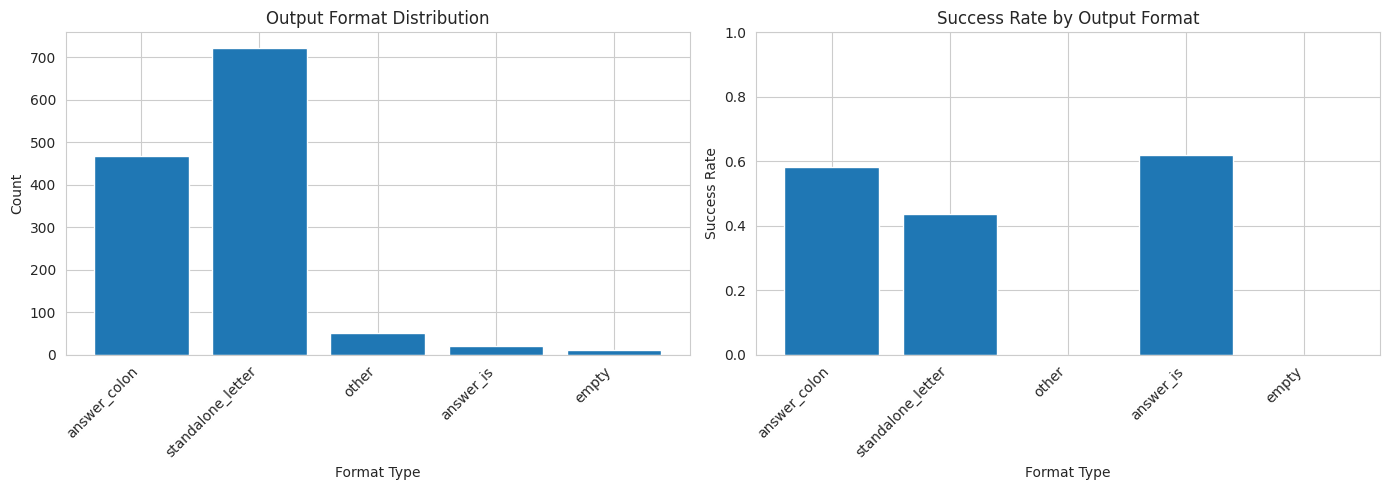

In [6]:
# Visualize output formats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Format distribution
ax1.bar(format_counter.keys(), format_counter.values())
ax1.set_title('Output Format Distribution')
ax1.set_ylabel('Count')
ax1.set_xlabel('Format Type')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Success rate by format
formats = list(format_success.keys())
success_rates = [format_success[f]['correct'] / format_success[f]['total'] for f in formats]
ax2.bar(formats, success_rates)
ax2.set_title('Success Rate by Output Format')
ax2.set_ylabel('Success Rate')
ax2.set_xlabel('Format Type')
ax2.set_ylim(0, 1)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 4. Sample Failure Cases


In [7]:
# Test alternative regex patterns
patterns = {
    'current': r'(?i)answer\W(?:is)*\W*([A-D])(?:\W|$)|(?:answer|boxed)?{\W*([A-D])\W+',
    'simple_letter': r'\b([A-D])\b',
    'answer_colon': r'(?i)answer\s*[:\-]?\s*([A-D])(?:\W|$)',
    'boxed_only': r'(?i)boxed\s*{\s*([A-D])\s*}',
    'answer_is': r'(?i)(?:the\s+)?answer\s+is\s+([A-D])(?:\W|$)',
    'flexible': r'(?i)(?:answer|boxed|final)\s*(?:is|:)?\s*[:\-]?\s*[{\[]?\s*([A-D])\s*[}\]]?',
}

pattern_results = {}

for pattern_name, pattern in patterns.items():
    correct = 0
    invalid = 0
    wrong = 0
    
    for sample in medqa_samples:
        target = sample.get('target', '')
        raw_resp = sample.get('resps', [['']])[0][0] if sample.get('resps') else ''
        
        extracted, _ = test_regex_extraction(raw_resp, pattern)
        
        if extracted is None:
            invalid += 1
        elif extracted == target:
            correct += 1
        else:
            wrong += 1
    
    pattern_results[pattern_name] = {
        'correct': correct,
        'invalid': invalid,
        'wrong': wrong,
        'total': len(medqa_samples),
        'success_rate': correct / len(medqa_samples),
    }

# Display results
df_patterns = pd.DataFrame(pattern_results).T
df_patterns['success_rate_pct'] = df_patterns['success_rate'] * 100
df_patterns['invalid_pct'] = (df_patterns['invalid'] / df_patterns['total']) * 100

print("Pattern Comparison Results:")
print(df_patterns[['success_rate_pct', 'invalid_pct', 'correct', 'invalid', 'wrong']].sort_values('success_rate_pct', ascending=False))


Pattern Comparison Results:
               success_rate_pct  invalid_pct  correct  invalid  wrong
simple_letter         50.432050     4.791830    642.0     61.0  570.0
current               47.132757    17.360566    600.0    221.0  452.0
flexible              24.116261    57.344855    307.0    730.0  236.0
answer_colon          21.759623    63.315004    277.0    806.0  190.0
answer_is              2.749411    95.051060     35.0   1210.0   28.0
boxed_only             0.000000   100.000000      0.0   1273.0    0.0


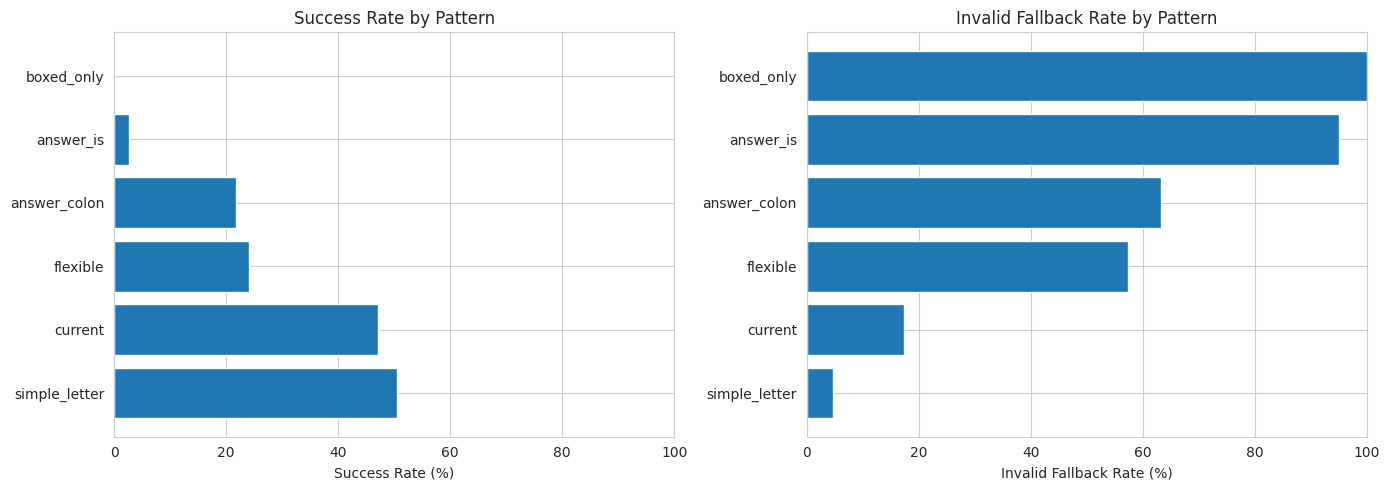

In [8]:
# Visualize pattern comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

patterns_sorted = df_patterns.sort_values('success_rate_pct', ascending=False)

ax1.barh(patterns_sorted.index, patterns_sorted['success_rate_pct'])
ax1.set_title('Success Rate by Pattern')
ax1.set_xlabel('Success Rate (%)')
ax1.set_xlim(0, 100)

ax2.barh(patterns_sorted.index, patterns_sorted['invalid_pct'])
ax2.set_title('Invalid Fallback Rate by Pattern')
ax2.set_xlabel('Invalid Fallback Rate (%)')
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()


In [10]:
# Find interesting failure cases
failure_cases = []

for sample in medqa_samples:
    target = sample.get('target', '')
    filtered_resp = sample.get('filtered_resps', [''])[0] if sample.get('filtered_resps') else ''
    raw_resp = sample.get('resps', [['']])[0][0] if sample.get('resps') else ''
    exact_match = sample.get('exact_match', 0)
    
    if exact_match == 0:
        failure_cases.append({
            'doc_id': sample.get('doc_id'),
            'target': target,
            'filtered': filtered_resp,
            'raw_output': raw_resp[:300],  # First 300 chars
            'format': categorize_output_format(raw_resp),
            'is_invalid': filtered_resp == '[invalid]',
        })

df_failures = pd.DataFrame(failure_cases)

print(f"Total failure cases: {len(df_failures)}")
print(f"\nInvalid fallback cases: {df_failures['is_invalid'].sum()}")

# Show examples of different failure types
print("\n=== Examples of Invalid Fallback Cases ===")
invalid_cases = df_failures[df_failures['is_invalid']].head(5)
for idx, row in invalid_cases.iterrows():
    print(f"\nDoc ID: {row['doc_id']}, Target: {row['target']}")
    print(f"Format: {row['format']}")
    print(f"Raw output: {row['raw_output'][:200]}...")

print("\n=== Examples of Wrong Answer Extracted ===")
wrong_cases = df_failures[(~df_failures['is_invalid']) & (df_failures['filtered'] != df_failures['target'])].head(5)
for idx, row in wrong_cases.iterrows():
    print(f"\nDoc ID: {row['doc_id']}, Target: {row['target']}, Extracted: {row['filtered']}")
    print(f"Format: {row['format']}")
    print(f"Raw output: {row['raw_output'][:200]}...")


Total failure cases: 673

Invalid fallback cases: 221

=== Examples of Invalid Fallback Cases ===

Doc ID: 4, Target: B
Format: standalone_letter
Raw output:  
A: The patient has allergic conjunctivitis, which is characterized by itching, tearing, and redness of the eyes. The patient's symptoms are consistent with this diagnosis. The patient's occupation a...

Doc ID: 5, Target: D
Format: other
Raw output:  
The patient is experiencing an acute coronary syndrome (ACS) due to cocaine-induced coronary artery spasm. The first step in management is to provide reassurance and continuous monitoring. The patie...

Doc ID: 11, Target: D
Format: standalone_letter
Raw output:  
A: The patient has a myeloproliferative neoplasm (MPN) with a JAK2 mutation. The most common MPNs are polycythemia vera, essential thrombocytosis, and primary myelofibrosis. The patient has primary ...

Doc ID: 13, Target: D
Format: standalone_letter
Raw output:  
A: 
The patient has a murmur of aortic stenosis. The murmu